# Flower Recognition with ResNet

In [ ]:
!pip install torch torchvision pandas numpy matplotlib scikit-learn pillow scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, classification_report
import scipy
from PIL import Image
import os
import shutil
import time
from tempfile import TemporaryDirectory
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cpu
Using device: cpu


In [ ]:
#setting up data loading and preprocessing
import os
import scipy.io
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image

#data directories
data_dir = 'data/flowers-102'
images_dir = os.path.join(data_dir, 'jpg')

# Load mat files for labels and train/val/test splits
labels = scipy.io.loadmat(os.path.join(data_dir, 'imagelabels.mat'))['labels'][0] - 1  # Convert to 0-based indexing
splits = scipy.io.loadmat(os.path.join(data_dir, 'setid.mat'))

# Get indices for train, val, and test sets
train_idx = splits['trnid'][0] - 1  # Convert to 0-based indexing
val_idx = splits['valid'][0] - 1
test_idx = splits['tstid'][0] - 1

class Flowers102Dataset(Dataset):
    def __init__(self, image_dir, indices, labels, transform=None):
        self.image_dir = image_dir
        self.indices = indices
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_idx = self.indices[idx]
        img_name = f'image_{img_idx+1:05d}.jpg'
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        label = self.labels[img_idx]
        return image, label

#defining transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# create datasets
train_dataset = Flowers102Dataset(images_dir, train_idx, labels, train_transform)
val_dataset = Flowers102Dataset(images_dir, val_idx, labels, val_test_transform)
test_dataset = Flowers102Dataset(images_dir, test_idx, labels, val_test_transform)

# create dataloaders
batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

#store dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

print(f"Dataset sizes:")
print(f"Training: {dataset_sizes['train']} images")
print(f"Validation: {dataset_sizes['val']} images")
print(f"Test: {dataset_sizes['test']} images")

Dataset sizes:
Training: 1020 images
Validation: 1020 images
Test: 6149 images


Training samples:


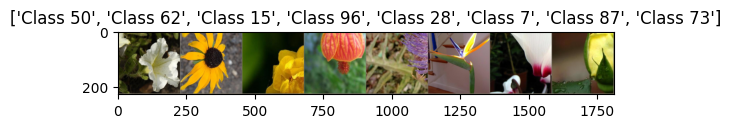

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

#visualise some training images
def visualize_samples(dataloader, num_images=8):
    inputs, classes = next(iter(dataloader))
    out = torchvision.utils.make_grid(inputs[:num_images])
    imshow(out, title=[f'Class {x}' for x in classes[:num_images]])

print("Training samples:")
visualize_samples(dataloaders['train'])

In [ ]:
#base ResNet Model
class FlowerResNet(nn.Module):
    def __init__(self, base_model='resnet18', pretrained=True, num_classes=102):
        super(FlowerResNet, self).__init__()
        
        if base_model == 'resnet18':
            if pretrained:
                self.backbone = models.resnet18(weights='IMAGENET1K_V1')
            else:
                self.backbone = models.resnet18(weights=None)
        elif base_model == 'resnet34':
            if pretrained:
                self.backbone = models.resnet34(weights='IMAGENET1K_V1')
            else:
                self.backbone = models.resnet34(weights=None)
        else:
            raise ValueError("Unsupported base model")
        
        # Replace the final fully connected layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.backbone(x)

#model with Frozen Stages
class FlowerResNetFrozen(nn.Module):
    def __init__(self, base_model='resnet18', num_frozen_stages=3, num_classes=102):
        super(FlowerResNetFrozen, self).__init__()
        
        if base_model == 'resnet18':
            self.backbone = models.resnet18(weights='IMAGENET1K_V1')
        elif base_model == 'resnet34':
            self.backbone = models.resnet34(weights='IMAGENET1K_V1')
        else:
            raise ValueError("Unsupported base model")
        
        # Freeze specified stages
        self._freeze_stages(num_frozen_stages)
        
        # Replace the final fully connected layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)
        
    def _freeze_stages(self, num_stages):
        """Freeze the first num_stages of ResNet"""
        if num_stages >= 1:
            for param in self.backbone.conv1.parameters():
                param.requires_grad = False
            for param in self.backbone.bn1.parameters():
                param.requires_grad = False
        if num_stages >= 2:
            for param in self.backbone.layer1.parameters():
                param.requires_grad = False
        if num_stages >= 3:
            for param in self.backbone.layer2.parameters():
                param.requires_grad = False
        if num_stages >= 4:
            for param in self.backbone.layer3.parameters():
                param.requires_grad = False
        if num_stages >= 5:
            for param in self.backbone.layer4.parameters():
                param.requires_grad = False
                
    def forward(self, x):
        return self.backbone(x)


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, model_name='resnet18'):
    since = time.time()
    
    # Create checkpoint directory
    checkpoint_path = './model_checkpoints'
    os.makedirs(checkpoint_path, exist_ok=True)
    best_model_params_path = os.path.join(checkpoint_path, f'best_{model_name}_params.pt')
    
    # Save initial model
    torch.save(model.state_dict(), best_model_params_path)
    
    # Track metrics
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has training and validation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data with progress bar
            pbar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}')
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Update progress bar
                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{torch.sum(preds == labels.data).item() / inputs.size(0):.4f}'
                })
            
            if phase == 'train' and scheduler is not None:
                scheduler.step()
            
            # Calculate epoch metrics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Store metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu())
            
            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)
                print(f'New best model saved with val_acc: {best_acc:.4f}')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    
    return model, train_losses, train_accs, val_losses, val_accs

In [8]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title(f'{model_name} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(train_accs, label='Train Acc')
    ax2.plot(val_accs, label='Val Acc')
    ax2.set_title(f'{model_name} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

def visualize_model_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 8))

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                
                # Color code correct/incorrect predictions
                color = 'green' if preds[j] == labels[j] else 'red'
                ax.set_title(f'Pred: {preds[j].item()} | True: {labels[j].item()}',
                           color=color, fontweight='bold')
                
                # Denormalize and show image
                inp = inputs.cpu().data[j]
                inp = inp.numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                ax.imshow(inp)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def evaluate_model(model, criterion):
    was_training = model.training
    model.eval()
    
    test_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []
    
    print("Evaluating on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            test_loss += criterion(outputs, labels).item() * inputs.size(0)
            correct += torch.sum(preds == labels.data)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss /= dataset_sizes['test']
    test_acc = correct.double() / dataset_sizes['test']
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')
    
    model.train(mode=was_training)
    return test_loss, test_acc, all_preds, all_labels

def plot_confusion_matrix(all_labels, all_preds, class_names=None):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=class_names if class_names else range(102),
                yticklabels=class_names if class_names else range(102))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

### Experiment 2 resnet-18 with 3 frozen stages

Trainable parameters: 10545766/11228838 (93.92%)
Epoch 0/49
----------
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 32/32 [00:07<00:00,  4.34it/s, Loss=4.5514, Acc=0.0357]


train Loss: 4.7557 Acc: 0.0157


Val Epoch 0: 100%|██████████| 32/32 [00:04<00:00,  7.25it/s, Loss=4.0162, Acc=0.1071]



val Loss: 4.4227 Acc: 0.0471
New best model saved with val_acc: 0.0471

Epoch 1/49
----------
New best model saved with val_acc: 0.0471

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s, Loss=4.2355, Acc=0.0714]


train Loss: 4.3051 Acc: 0.0745


Val Epoch 1: 100%|██████████| 32/32 [00:04<00:00,  7.64it/s, Loss=3.5237, Acc=0.4643]



val Loss: 3.9703 Acc: 0.2127
New best model saved with val_acc: 0.2127

Epoch 2/49
----------
New best model saved with val_acc: 0.2127

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 32/32 [00:07<00:00,  4.42it/s, Loss=3.7410, Acc=0.3214]


train Loss: 3.8614 Acc: 0.2892


Val Epoch 2: 100%|██████████| 32/32 [00:04<00:00,  7.36it/s, Loss=3.0009, Acc=0.7143]



val Loss: 3.4903 Acc: 0.4167
New best model saved with val_acc: 0.4167

Epoch 3/49
----------
New best model saved with val_acc: 0.4167

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 32/32 [00:06<00:00,  4.60it/s, Loss=2.9461, Acc=0.7857]


train Loss: 3.3898 Acc: 0.4725


Val Epoch 3: 100%|██████████| 32/32 [00:04<00:00,  7.75it/s, Loss=2.2624, Acc=0.9286]



val Loss: 3.0142 Acc: 0.5618
New best model saved with val_acc: 0.5618

Epoch 4/49
----------
New best model saved with val_acc: 0.5618

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 32/32 [00:06<00:00,  4.58it/s, Loss=2.8208, Acc=0.6071]


train Loss: 2.9682 Acc: 0.5941


Val Epoch 4: 100%|██████████| 32/32 [00:04<00:00,  7.47it/s, Loss=1.5881, Acc=0.9643]



val Loss: 2.5509 Acc: 0.6559
New best model saved with val_acc: 0.6559

Epoch 5/49
----------
New best model saved with val_acc: 0.6559

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 32/32 [00:07<00:00,  4.53it/s, Loss=2.2221, Acc=0.7857]


train Loss: 2.5911 Acc: 0.6902


Val Epoch 5: 100%|██████████| 32/32 [00:04<00:00,  7.61it/s, Loss=1.2846, Acc=0.9286]



val Loss: 2.1898 Acc: 0.7118
New best model saved with val_acc: 0.7118

Epoch 6/49
----------
New best model saved with val_acc: 0.7118

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 32/32 [00:07<00:00,  4.28it/s, Loss=1.8823, Acc=0.8571]


train Loss: 2.2331 Acc: 0.7284


Val Epoch 6: 100%|██████████| 32/32 [00:04<00:00,  7.44it/s, Loss=1.1438, Acc=0.9643]



val Loss: 1.8617 Acc: 0.7422
New best model saved with val_acc: 0.7422

Epoch 7/49
----------
New best model saved with val_acc: 0.7422

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s, Loss=2.0263, Acc=0.7143]


train Loss: 1.9834 Acc: 0.7873


Val Epoch 7: 100%|██████████| 32/32 [00:04<00:00,  7.57it/s, Loss=0.8998, Acc=0.9286]



val Loss: 1.6434 Acc: 0.7696
New best model saved with val_acc: 0.7696

Epoch 8/49
----------
New best model saved with val_acc: 0.7696

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 32/32 [00:07<00:00,  4.48it/s, Loss=1.6387, Acc=0.7143]


train Loss: 1.7492 Acc: 0.8029


Val Epoch 8: 100%|██████████| 32/32 [00:04<00:00,  7.92it/s, Loss=0.8151, Acc=0.9643]



val Loss: 1.4535 Acc: 0.7990
New best model saved with val_acc: 0.7990

Epoch 9/49
----------
New best model saved with val_acc: 0.7990

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 32/32 [00:06<00:00,  4.68it/s, Loss=1.9231, Acc=0.6786]


train Loss: 1.5483 Acc: 0.8225


Val Epoch 9: 100%|██████████| 32/32 [00:04<00:00,  7.44it/s, Loss=0.7577, Acc=1.0000]



val Loss: 1.3002 Acc: 0.8294
New best model saved with val_acc: 0.8294

Epoch 10/49
----------
New best model saved with val_acc: 0.8294

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 32/32 [00:07<00:00,  4.56it/s, Loss=1.5249, Acc=0.7857]


train Loss: 1.3600 Acc: 0.8578


Val Epoch 10: 100%|██████████| 32/32 [00:04<00:00,  7.61it/s, Loss=0.6224, Acc=1.0000]



val Loss: 1.1591 Acc: 0.8333
New best model saved with val_acc: 0.8333

Epoch 11/49
----------
New best model saved with val_acc: 0.8333

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s, Loss=1.0960, Acc=0.9286]


train Loss: 1.2313 Acc: 0.8765


Val Epoch 11: 100%|██████████| 32/32 [00:04<00:00,  7.61it/s, Loss=0.6187, Acc=1.0000]



val Loss: 1.0665 Acc: 0.8578
New best model saved with val_acc: 0.8578

Epoch 12/49
----------
New best model saved with val_acc: 0.8578

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 32/32 [00:07<00:00,  4.54it/s, Loss=0.8377, Acc=0.8929]


train Loss: 1.1440 Acc: 0.8696


Val Epoch 12: 100%|██████████| 32/32 [00:04<00:00,  7.52it/s, Loss=0.5764, Acc=0.9643]



val Loss: 0.9754 Acc: 0.8667
New best model saved with val_acc: 0.8667

Epoch 13/49
----------
New best model saved with val_acc: 0.8667

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s, Loss=1.0982, Acc=0.8214]


train Loss: 1.0235 Acc: 0.8941


Val Epoch 13: 100%|██████████| 32/32 [00:05<00:00,  6.37it/s, Loss=0.5339, Acc=1.0000]



val Loss: 0.8999 Acc: 0.8735
New best model saved with val_acc: 0.8735

Epoch 14/49
----------
New best model saved with val_acc: 0.8735

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 32/32 [00:07<00:00,  4.42it/s, Loss=0.9332, Acc=0.8929]


train Loss: 0.9164 Acc: 0.9039


Val Epoch 14: 100%|██████████| 32/32 [00:04<00:00,  7.04it/s, Loss=0.4161, Acc=0.9643]


val Loss: 0.8405 Acc: 0.8706

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s, Loss=0.8859, Acc=0.8929]


train Loss: 0.8396 Acc: 0.9127


Val Epoch 15: 100%|██████████| 32/32 [00:04<00:00,  7.84it/s, Loss=0.4744, Acc=0.9643]



val Loss: 0.7967 Acc: 0.8784
New best model saved with val_acc: 0.8784

Epoch 16/49
----------
New best model saved with val_acc: 0.8784

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 32/32 [00:07<00:00,  4.48it/s, Loss=0.9638, Acc=0.8929]


train Loss: 0.7821 Acc: 0.9118


Val Epoch 16: 100%|██████████| 32/32 [00:04<00:00,  7.78it/s, Loss=0.4264, Acc=0.9643]



val Loss: 0.7501 Acc: 0.8853
New best model saved with val_acc: 0.8853

Epoch 17/49
----------
New best model saved with val_acc: 0.8853

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 32/32 [00:10<00:00,  2.96it/s, Loss=0.6973, Acc=0.9286]


train Loss: 0.7031 Acc: 0.9314


Val Epoch 17: 100%|██████████| 32/32 [00:04<00:00,  7.60it/s, Loss=0.4329, Acc=0.9643]



val Loss: 0.7131 Acc: 0.8892
New best model saved with val_acc: 0.8892

Epoch 18/49
----------
New best model saved with val_acc: 0.8892

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 32/32 [00:06<00:00,  4.77it/s, Loss=0.4212, Acc=0.9643]


train Loss: 0.7313 Acc: 0.9069


Val Epoch 18: 100%|██████████| 32/32 [00:04<00:00,  7.79it/s, Loss=0.3518, Acc=0.9643]



val Loss: 0.6831 Acc: 0.8951
New best model saved with val_acc: 0.8951

Epoch 19/49
----------
New best model saved with val_acc: 0.8951

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 32/32 [00:07<00:00,  4.46it/s, Loss=0.7380, Acc=0.9643]


train Loss: 0.6680 Acc: 0.9216


Val Epoch 19: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s, Loss=0.3767, Acc=0.9643]



val Loss: 0.6557 Acc: 0.8971
New best model saved with val_acc: 0.8971

Epoch 20/49
----------
New best model saved with val_acc: 0.8971

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 32/32 [00:06<00:00,  4.77it/s, Loss=0.4197, Acc=1.0000]


train Loss: 0.6069 Acc: 0.9343


Val Epoch 20: 100%|██████████| 32/32 [00:04<00:00,  7.95it/s, Loss=0.3840, Acc=0.9643]


val Loss: 0.6238 Acc: 0.8961

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 32/32 [00:06<00:00,  4.58it/s, Loss=0.5089, Acc=0.9286]


train Loss: 0.5777 Acc: 0.9324


Val Epoch 21: 100%|██████████| 32/32 [00:04<00:00,  7.78it/s, Loss=0.3221, Acc=0.9643]


val Loss: 0.6149 Acc: 0.8961

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 32/32 [00:06<00:00,  4.71it/s, Loss=0.3690, Acc=0.9643]


train Loss: 0.5418 Acc: 0.9412


Val Epoch 22: 100%|██████████| 32/32 [00:04<00:00,  7.65it/s, Loss=0.3083, Acc=0.9643]



val Loss: 0.5821 Acc: 0.9039
New best model saved with val_acc: 0.9039

Epoch 23/49
----------
New best model saved with val_acc: 0.9039

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 32/32 [00:06<00:00,  4.85it/s, Loss=0.5589, Acc=0.8929]


train Loss: 0.5012 Acc: 0.9480


Val Epoch 23: 100%|██████████| 32/32 [00:04<00:00,  7.76it/s, Loss=0.3490, Acc=0.9643]



val Loss: 0.5640 Acc: 0.9088
New best model saved with val_acc: 0.9088

Epoch 24/49
----------
New best model saved with val_acc: 0.9088

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 32/32 [00:07<00:00,  4.56it/s, Loss=0.4844, Acc=0.9643]


train Loss: 0.4962 Acc: 0.9451


Val Epoch 24: 100%|██████████| 32/32 [00:04<00:00,  7.70it/s, Loss=0.3128, Acc=0.9643]


val Loss: 0.5514 Acc: 0.9039

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 32/32 [00:06<00:00,  4.83it/s, Loss=0.5100, Acc=0.9286]


train Loss: 0.4490 Acc: 0.9510


Val Epoch 25: 100%|██████████| 32/32 [00:04<00:00,  7.71it/s, Loss=0.3545, Acc=0.9643]


val Loss: 0.5397 Acc: 0.9078

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 32/32 [00:07<00:00,  4.37it/s, Loss=0.5672, Acc=0.9286]


train Loss: 0.4567 Acc: 0.9500


Val Epoch 26: 100%|██████████| 32/32 [00:04<00:00,  7.89it/s, Loss=0.3091, Acc=0.9643]



val Loss: 0.5229 Acc: 0.9108
New best model saved with val_acc: 0.9108

Epoch 27/49
----------
New best model saved with val_acc: 0.9108

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 32/32 [00:07<00:00,  4.50it/s, Loss=0.2683, Acc=0.9643]


train Loss: 0.4339 Acc: 0.9451


Val Epoch 27: 100%|██████████| 32/32 [00:04<00:00,  7.62it/s, Loss=0.2984, Acc=0.9643]


val Loss: 0.5114 Acc: 0.9098

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s, Loss=0.2684, Acc=1.0000]


train Loss: 0.4113 Acc: 0.9549


Val Epoch 28: 100%|██████████| 32/32 [00:04<00:00,  7.91it/s, Loss=0.2908, Acc=0.9643]



val Loss: 0.5002 Acc: 0.9118
New best model saved with val_acc: 0.9118

Epoch 29/49
----------
New best model saved with val_acc: 0.9118

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 32/32 [00:06<00:00,  4.63it/s, Loss=0.2921, Acc=1.0000]


train Loss: 0.3831 Acc: 0.9500


Val Epoch 29: 100%|██████████| 32/32 [00:04<00:00,  7.76it/s, Loss=0.3057, Acc=0.9643]



val Loss: 0.5010 Acc: 0.9127
New best model saved with val_acc: 0.9127

Epoch 30/49
----------
New best model saved with val_acc: 0.9127

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s, Loss=0.3574, Acc=0.9643]


train Loss: 0.3953 Acc: 0.9461


Val Epoch 30: 100%|██████████| 32/32 [00:04<00:00,  7.68it/s, Loss=0.2899, Acc=0.9643]


val Loss: 0.4886 Acc: 0.9088

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 32/32 [00:06<00:00,  4.62it/s, Loss=0.4378, Acc=0.8929]


train Loss: 0.3676 Acc: 0.9598


Val Epoch 31: 100%|██████████| 32/32 [00:04<00:00,  7.92it/s, Loss=0.2722, Acc=0.9643]


val Loss: 0.4892 Acc: 0.9108

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s, Loss=0.3622, Acc=0.9643]


train Loss: 0.3645 Acc: 0.9608


Val Epoch 32: 100%|██████████| 32/32 [00:04<00:00,  7.78it/s, Loss=0.2818, Acc=0.9643]



val Loss: 0.4905 Acc: 0.9157
New best model saved with val_acc: 0.9157

Epoch 33/49
----------
New best model saved with val_acc: 0.9157

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 32/32 [00:06<00:00,  4.72it/s, Loss=0.2740, Acc=0.9643]


train Loss: 0.3435 Acc: 0.9657


Val Epoch 33: 100%|██████████| 32/32 [00:04<00:00,  7.74it/s, Loss=0.2819, Acc=0.9643]


val Loss: 0.4859 Acc: 0.9088

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 32/32 [00:06<00:00,  4.60it/s, Loss=0.3261, Acc=0.9643]


train Loss: 0.3440 Acc: 0.9667


Val Epoch 34: 100%|██████████| 32/32 [00:04<00:00,  7.72it/s, Loss=0.2685, Acc=0.9643]


val Loss: 0.4821 Acc: 0.9157

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 32/32 [00:07<00:00,  4.46it/s, Loss=0.2753, Acc=1.0000]


train Loss: 0.3613 Acc: 0.9618


Val Epoch 35: 100%|██████████| 32/32 [00:04<00:00,  7.21it/s, Loss=0.2685, Acc=0.9643]


val Loss: 0.4900 Acc: 0.9127

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 32/32 [00:06<00:00,  4.68it/s, Loss=0.3269, Acc=0.9643]


train Loss: 0.3161 Acc: 0.9686


Val Epoch 36: 100%|██████████| 32/32 [00:04<00:00,  7.73it/s, Loss=0.2736, Acc=0.9643]


val Loss: 0.4859 Acc: 0.9127

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 32/32 [00:06<00:00,  4.71it/s, Loss=0.3795, Acc=0.8929]


train Loss: 0.3350 Acc: 0.9569


Val Epoch 37: 100%|██████████| 32/32 [00:04<00:00,  7.74it/s, Loss=0.2785, Acc=0.9643]


val Loss: 0.4853 Acc: 0.9137

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 32/32 [00:07<00:00,  4.22it/s, Loss=0.3881, Acc=0.9643]


train Loss: 0.3375 Acc: 0.9676


Val Epoch 38: 100%|██████████| 32/32 [00:04<00:00,  7.62it/s, Loss=0.2685, Acc=0.9643]


val Loss: 0.4877 Acc: 0.9127

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s, Loss=0.2936, Acc=0.9643]


train Loss: 0.3894 Acc: 0.9510


Val Epoch 39: 100%|██████████| 32/32 [00:04<00:00,  7.60it/s, Loss=0.2740, Acc=0.9643]


val Loss: 0.4885 Acc: 0.9088

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s, Loss=0.4002, Acc=0.9286]


train Loss: 0.3555 Acc: 0.9539


Val Epoch 40: 100%|██████████| 32/32 [00:04<00:00,  7.65it/s, Loss=0.2539, Acc=0.9643]


val Loss: 0.4792 Acc: 0.9127

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 32/32 [00:07<00:00,  4.48it/s, Loss=0.4607, Acc=0.9643]


train Loss: 0.3685 Acc: 0.9618


Val Epoch 41: 100%|██████████| 32/32 [00:04<00:00,  7.84it/s, Loss=0.2704, Acc=0.9643]


val Loss: 0.4789 Acc: 0.9147

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s, Loss=0.5226, Acc=0.9286]


train Loss: 0.3693 Acc: 0.9539


Val Epoch 42: 100%|██████████| 32/32 [00:04<00:00,  7.66it/s, Loss=0.2841, Acc=0.9643]


val Loss: 0.4833 Acc: 0.9098

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s, Loss=0.3640, Acc=0.9286]


train Loss: 0.3503 Acc: 0.9608


Val Epoch 43: 100%|██████████| 32/32 [00:04<00:00,  7.58it/s, Loss=0.2590, Acc=0.9643]


val Loss: 0.4841 Acc: 0.9118

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 32/32 [00:07<00:00,  4.29it/s, Loss=0.3082, Acc=1.0000]


train Loss: 0.3372 Acc: 0.9598


Val Epoch 44: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s, Loss=0.2697, Acc=0.9643]


val Loss: 0.4743 Acc: 0.9147

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s, Loss=0.3347, Acc=1.0000]


train Loss: 0.3434 Acc: 0.9598


Val Epoch 45: 100%|██████████| 32/32 [00:04<00:00,  7.57it/s, Loss=0.2400, Acc=0.9643]


val Loss: 0.4768 Acc: 0.9147

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 32/32 [00:06<00:00,  4.65it/s, Loss=0.4152, Acc=0.9286]


train Loss: 0.3527 Acc: 0.9569


Val Epoch 46: 100%|██████████| 32/32 [00:04<00:00,  7.82it/s, Loss=0.2669, Acc=0.9643]


val Loss: 0.4803 Acc: 0.9118

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s, Loss=0.1600, Acc=1.0000]


train Loss: 0.3566 Acc: 0.9539


Val Epoch 47: 100%|██████████| 32/32 [00:04<00:00,  7.34it/s, Loss=0.2533, Acc=0.9643]


val Loss: 0.4786 Acc: 0.9108

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s, Loss=0.2243, Acc=1.0000]


train Loss: 0.3277 Acc: 0.9618


Val Epoch 48: 100%|██████████| 32/32 [00:04<00:00,  7.46it/s, Loss=0.2645, Acc=0.9643]


val Loss: 0.4756 Acc: 0.9098

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 32/32 [00:07<00:00,  4.15it/s, Loss=0.2720, Acc=1.0000]


train Loss: 0.3368 Acc: 0.9627


Val Epoch 49: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s, Loss=0.2627, Acc=0.9643]



val Loss: 0.4666 Acc: 0.9157

Training complete in 9m 42s
Best val Acc: 0.915686


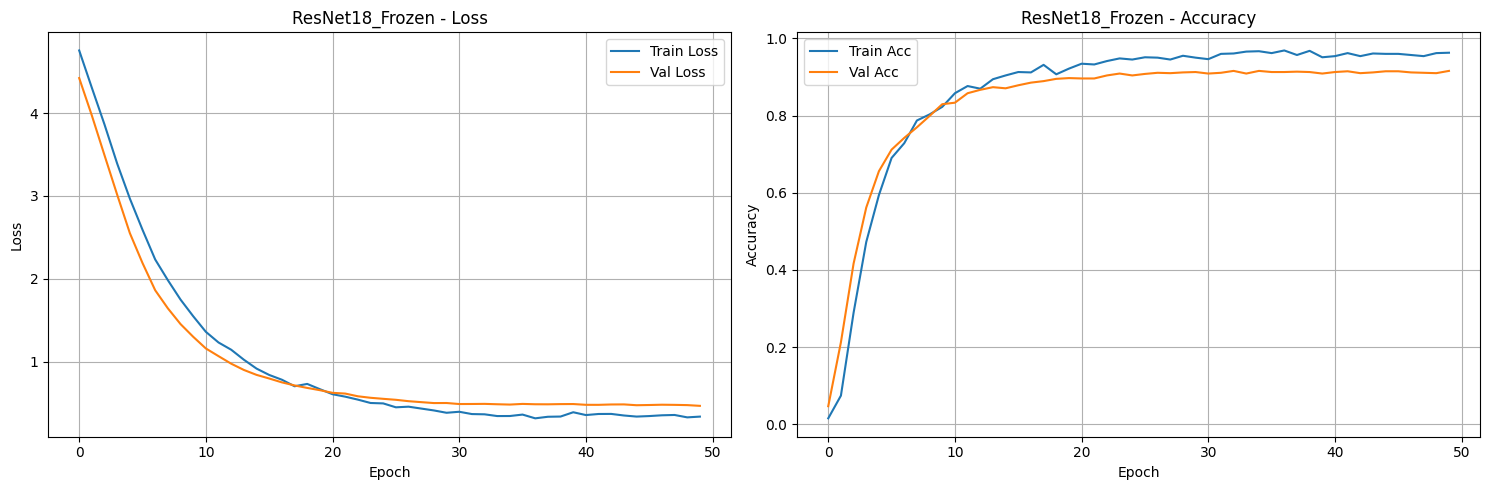

Evaluating on test set...


100%|██████████| 193/193 [00:20<00:00,  9.35it/s]

Test Loss: 0.5767
Test Accuracy: 0.8868
ResNet18 Frozen - Test Accuracy: 0.8868


In [ ]:

#create model with three frozen stages
model_frozen = FlowerResNetFrozen(base_model='resnet18', num_frozen_stages=3, num_classes=102)
model_frozen = model_frozen.to(device)
num_epochs = 50
criterion = nn.CrossEntropyLoss()

#count trainable parameters
trainable_params = sum(p.numel() for p in model_frozen.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_frozen.parameters())
print(f"Trainable parameters: {trainable_params}/{total_params} ({trainable_params/total_params*100:.2f}%)")

#define optimizer for only trainable parameters
optimizer_ft = optim.SGD(
    filter(lambda p: p.requires_grad, model_frozen.parameters()), 
    lr=0.001, momentum=0.9
)
scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

#train model
model_frozen, train_losses_f, train_accs_f, val_losses_f, val_accs_f = train_model(
    model_frozen, criterion, optimizer_ft, scheduler_ft, num_epochs, 'resnet18_frozen'
)

#plot results
plot_training_curves(train_losses_f, val_losses_f, train_accs_f, val_accs_f, 'ResNet18_Frozen')

#evaluate on test set
test_loss_f, test_acc_f, all_preds_f, all_labels_f = evaluate_model(model_frozen, criterion)

#save the training logs
with open('resnet18_frozen.txt', 'w') as f:
    f.write("Epoch,Train_Loss,Val_Loss,Train_Acc,Val_Acc\n")
    for epoch in range(num_epochs):
        f.write(f"{epoch+1},{train_losses_f[epoch]:.4f},{val_losses_f[epoch]:.4f},{train_accs_f[epoch]:.4f},{val_accs_f[epoch]:.4f}\n")

print(f"ResNet18 Frozen - Test Accuracy: {test_acc_f:.4f}")